In [1]:
!pip install librosa


  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached pycparser-2.23-py3-none-any.whl.metadata (993 bytes)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached certifi-2025.11.12-py3-none-any.whl.metadata (2.5 kB)
   ---------------------------------------- 0.0/260.7 kB ? eta -:--:--
   ----------------------- ---------------- 153.6/260.7 kB 4.5 MB/s eta 0:00:01
   ---------------------------------------- 260.7/260.7 kB 4.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/72.7 kB ? eta -:--:--
   ---------------------------------------- 72.7/72.7 kB ? eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 10.2 MB/s eta 0:00:01
   ------------ --------------------------- 0.9/2.8 MB 11.3 MB/s eta 0:00:01
   ----------------- ---------------------- 1.2/2.8 MB 9.5 MB/s eta 0:00:01
   ------------------------- -------------- 1.7/2.8 MB 10.1 MB/s e

In [6]:
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import scipy

In [4]:


# Définir les chemins 
base_path = "data"
dir_packet_loss = os.path.join(base_path, "packet_loss", "train_small")
dir_voice_origin = os.path.join(base_path, "voice_origin", "train_small")

# Fonction pour récupérer le premier fichier wav d'un dossier
def get_first_wav(directory):
    files = os.listdir(directory)
    for file in files:
        if file.endswith(".wav"):
            return os.path.join(directory, file)
    return None

# Récupérer les chemins des fichiers
file_pl = get_first_wav(dir_packet_loss)
file_vo = get_first_wav(dir_voice_origin)

# Charger les fichiers audio
if file_pl:
    y_pl, sr_pl = librosa.load(file_pl, sr=None) 
    print(f"Fichier Packet Loss chargé : {file_pl}")
    print(f"Dimensions : {y_pl.shape}, Fréquence : {sr_pl} Hz")

if file_vo:
    y_vo, sr_vo = librosa.load(file_vo, sr=None)
    print(f"Fichier Voice Origin chargé : {file_vo}")
    print(f"Dimensions : {y_vo.shape}, Fréquence : {sr_vo} Hz")

Fichier Packet Loss chargé : data\packet_loss\train_small\Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav
Dimensions : (80000,), Fréquence : 8000 Hz
Fichier Voice Origin chargé : data\voice_origin\train_small\Jules_Verne_-_L_ile_mysterieuse_Partie1_Chap01_0_.wav
Dimensions : (40000,), Fréquence : 4000 Hz


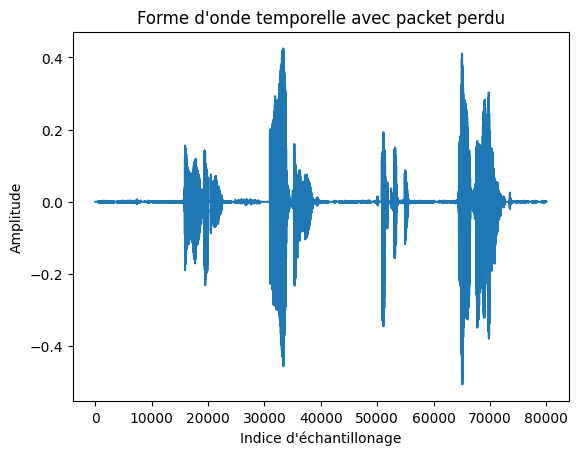

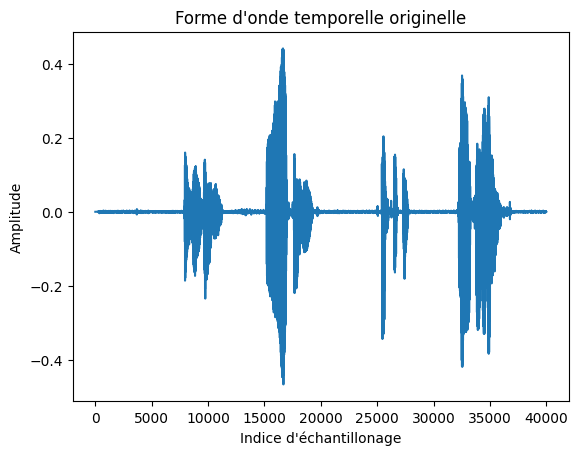

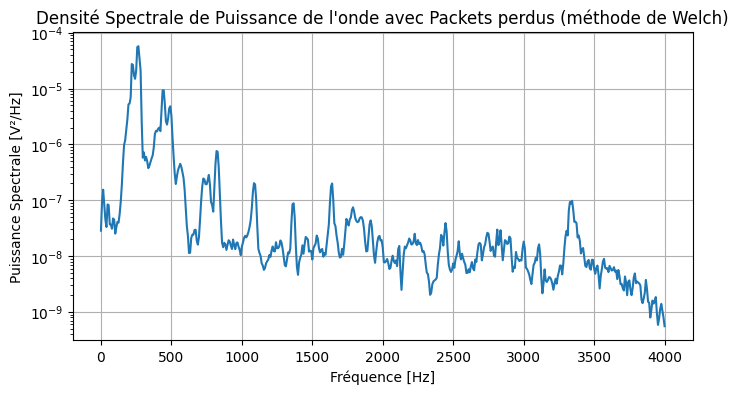

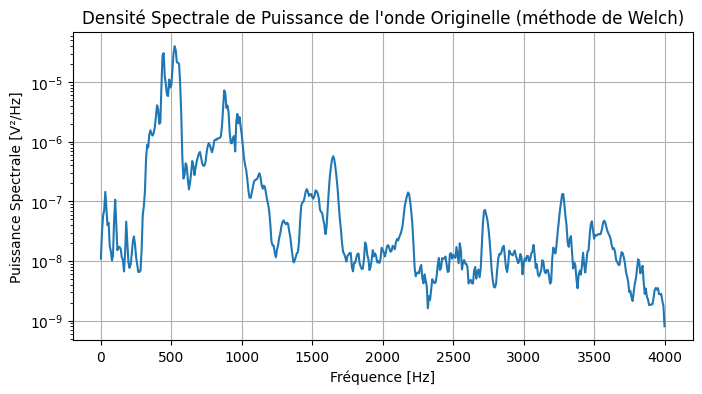

In [16]:
### FORME d'onde TEMPORELLE ###
T=[i for i in range(len(y_pl))]
plt.plot(T, y_pl)
plt.title("Forme d'onde temporelle avec packet perdu")
plt.xlabel("Indice d'échantillonage")
plt.ylabel("Amplitude")
plt.show()

plt.plot(T[0:len(y_vo)],y_vo)
plt.title("Forme d'onde temporelle originelle")
plt.xlabel("Indice d'échantillonage")
plt.ylabel("Amplitude")
plt.show()

### DENSITE SPECTRALE ###


# --- Calcul de la Densité Spectrale de Puissance (DSP) ---
frequencies, psd = scipy.signal.welch(y_pl, fs=8000, nperseg=1024)

# --- Affichage ---
plt.figure(figsize=(8, 4))
plt.semilogy(frequencies, psd)
plt.title("Densité Spectrale de Puissance de l'onde avec Packets perdus (méthode de Welch)")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Puissance Spectrale [V²/Hz]")
plt.grid(True)
plt.show()

# --- Calcul de la Densité Spectrale de Puissance (DSP) ---
frequencies, psd = scipy.signal.welch(y_vo, fs=8000, nperseg=1024)

# --- Affichage ---
plt.figure(figsize=(8, 4))
plt.semilogy(frequencies, psd)
plt.title("Densité Spectrale de Puissance de l'onde Originelle (méthode de Welch)")
plt.xlabel("Fréquence [Hz]")
plt.ylabel("Puissance Spectrale [V²/Hz]")
plt.grid(True)
plt.show()

C:\Users\valex\AppData\Local\Temp\ipykernel_21880\3670535170.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 * np.log10(Sxx_empty), shading='gouraud')


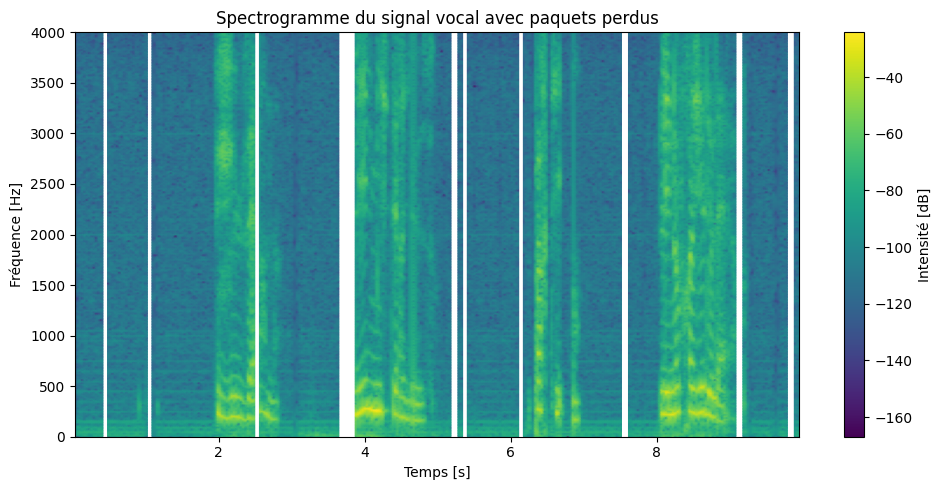

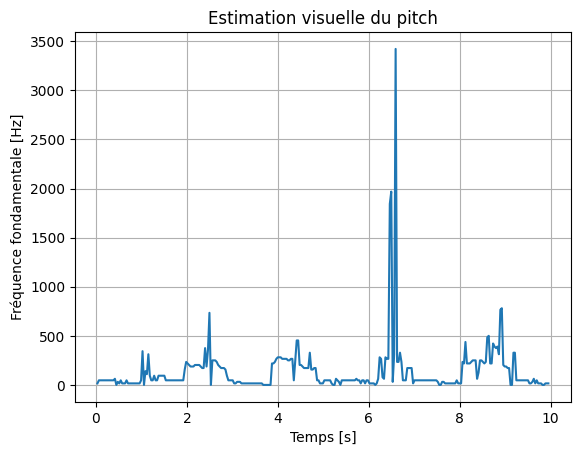

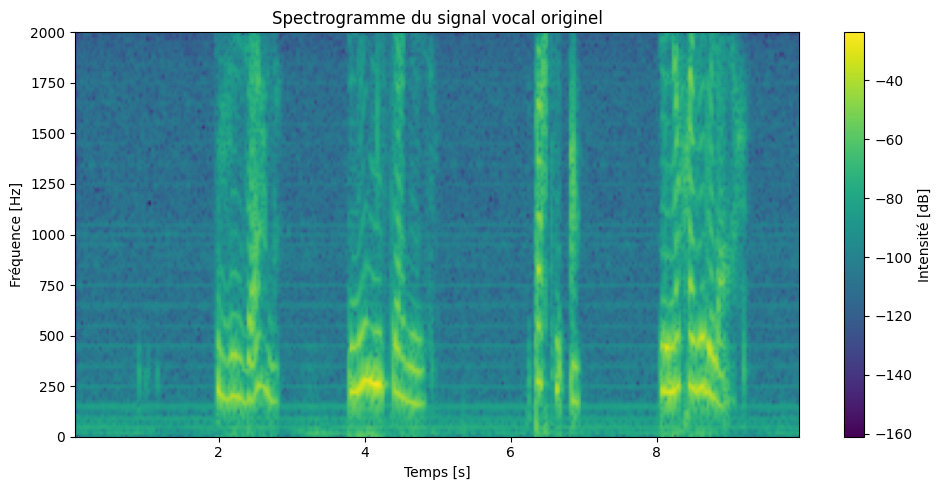

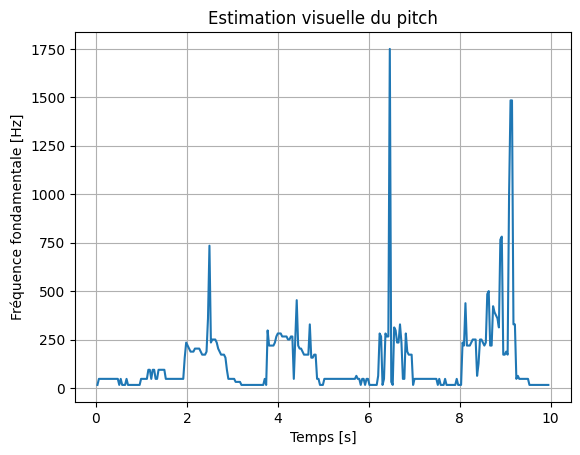

In [ ]:
# --- Calcul du spectrogramme ---
f, t, Sxx_empty = scipy.signal.spectrogram(y_pl, fs=8000, nperseg=512, noverlap=256)


# --- Affichage ---
plt.figure(figsize=(10, 5))
plt.pcolormesh(t, f, 10 * np.log10(Sxx_empty), shading='gouraud')
plt.title("Spectrogramme du signal vocal avec paquets perdus")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence [Hz]")
plt.colorbar(label="Intensité [dB]")
plt.tight_layout()
plt.show()

pitch_estim = f[np.argmax(Sxx_empty, axis=0)]

plt.plot(t, pitch_estim)
plt.title("Estimation visuelle du pitch")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence fondamentale [Hz]")
plt.grid(True)
plt.show()


# --- Calcul du spectrogramme ---
f, t, Sxx = scipy.signal.spectrogram(y_vo, fs=4000, nperseg=256, noverlap=128)


# --- Affichage ---
plt.figure(figsize=(10, 5))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.title("Spectrogramme du signal vocal originel")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence [Hz]")
plt.colorbar(label="Intensité [dB]")
plt.tight_layout()
plt.show()
pitch_estim = f[np.argmax(Sxx, axis=0)]

plt.plot(t, pitch_estim)
plt.title("Estimation visuelle du pitch")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence fondamentale [Hz]")
plt.grid(True)
plt.show()

In [ ]:
print(t[y_pl==0])
print(len(Sxx_empty[Sxx_empty==0]))

print(t[(Sxx_empty==0)[1,:]])

IndexError: boolean index did not match indexed array along axis 0; size of axis is 311 but size of corresponding boolean axis is 80000